In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

%matplotlib inline

### Initial Functions


In [3]:
# Define a function for cropping and resizing images while maintaining aspect ratio
def crop_and_resize(image, target_w=224, target_h=224):
    '''This function crops and resizes images to the target size while preserving the aspect ratio.'''

    # Check if the image is grayscale or RGB
    if image.ndim == 2:
        img_h, img_w = image.shape  # For Grayscale, set image height and width
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape  # For RGB, set image height, width, and channels

    # Calculate aspect ratios for the target and input images
    target_aspect_ratio = target_w / target_h
    input_aspect_ratio = img_w / img_h

    # Resize the image based on the aspect ratio comparison
    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio * target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w, resize_h))

        # Calculate cropping parameters for left/right equally
        crop_left = int((resize_w - target_w) / 2)
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]

    elif input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w / input_aspect_ratio)
        img = cv2.resize(image, (resize_w, resize_h))

        # Calculate cropping parameters for top and bottom
        crop_top = int((resize_h - target_h) / 4)  # Crop the top by 1/4 and bottom by 3/4 (can be changed)
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]

    else:  # If the aspect ratios are equal, simply resize the image
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img


In [5]:
# Define a function to display images from a dataframe with processing
def display_images_with_processing(num, dataframe, image_indices, title, ncols=4, target_width=224, target_height=224):
    '''
    This function displays images from a dataframe using specified indices,
    along with cropping and resizing.

    Args:
    - num: Total number of images to display
    - dataframe: DataFrame containing image data
    - image_indices: List of indices indicating which images to display
    - title: Title for the entire display
    - ncols: Number of columns for the image grid (default is 4)
    - target_width: Target width for cropping and resizing (default is 224)
    - target_height: Target height for cropping and resizing (default is 224)
    '''
    ncols = ncols
    nrows = int(num / ncols)

    # Create a subplot for displaying images
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4), sharex=True, sharey=True)
    fig.suptitle(title, size=20)
    axes = axes.ravel()

    # Loop through the specified image indices
    for i, img_idx in enumerate(image_indices):
        # Get the original image array from the dataframe
        original_image = dataframe.loc[img_idx, 'img_array']

        # Process the image using the crop_and_resize function
        processed_image = crop_and_resize(original_image, target_w=target_width, target_h=target_height)

        # Display the processed image with its associated face shape label
        axes[i].imshow(processed_image, cmap='rgb')
        axes[i].set_title(dataframe.loc[img_idx, 'face_shape'], size=16)


In [6]:
# Define a function to display images from an array dataset with processing
def display_images_from_array(num, image_array, title, ncols=4, target_width=224, target_height=224):
    '''
    This function displays images from an array dataset, along with a cropping and resizing process.

    Args:
    - num: Total number of images to display
    - image_array: Array containing image data and associated labels
    - title: Title for the entire display
    - ncols: Number of columns for the image grid (default is 4)
    - target_width: Target width for cropping and resizing (default is 224)
    - target_height: Target height for cropping and resizing (default is 224)
    '''
    ncols = ncols
    nrows = int(num / ncols)

    # Create a subplot for displaying images
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4), sharex=True, sharey=True)
    fig.suptitle(title, size=20)
    axes = axes.ravel()

    # Loop through the image array
    for i, img_data in enumerate(image_array):
        # Extract original image and label from the array
        original_image = img_data[0]

        # Process the image using the crop_and_resize function
        processed_image = crop_and_resize(original_image, target_w=target_width, target_h=target_height)

        # Display the processed image with its associated label
        axes[i].imshow(processed_image, cmap='rgb')
        axes[i].set_title(label_shape.get(img_data[1]), size=16)



# import and quality of dataset


In [7]:
train_dir = 'C:/Users/iamso/DataspellProjects/virtuka_classification/data/Face Shape 7s/Face Shape/Train'
test_dir = 'C:/Users/iamso/DataspellProjects/virtuka_classification/data/Face Shape 7s/Face Shape/Test'
categories = ['Diamond','Oblong','Oval','Round','Square','Triangle']

In [8]:
label_shape = {0:'Diamond', 1:'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square', 5:'Triangle'}

In [9]:
# Define a function to generate data files from images in a specified directory
def generate_data_files(directory, dataset_array, resize=None):
    '''
    This function reads images from the specified directory and creates training and testing datasets.

    Args:
    - directory: Path to the root directory containing image subdirectories
    - dataset_array: Array to store image data and associated labels
    - resize: Tuple specifying the target size for image resizing (default is None)
    '''
    i = 0

    # Loop through each category (subdirectory) in the specified directory
    for category in categories:
        path = os.path.join(directory, category)  # Path to the image directory
        class_num = categories.index(category)    # Assign a number to the categories
        img_list = os.listdir(path)

        try:
            # Loop through each image in the current category
            for img in img_list:
                img_array = cv2.imread(os.path.join(path, img), cv2.COLOR_BGR2RGB)

                # Resize the image if the 'resize' parameter is specified
                if resize is not None:
                    img_array = cv2.resize(img_array, resize)

                # Append the image array and its class number to the dataset array
                dataset_array.append([img_array, class_num])
                i += 1
        except Exception as e:
            # Handle errors and print details of the error
            print(f'Error: \n Category: {category}\n Image: {img}')

        # Print progress every 200 images
        if i % 200 == 0:
            print(f"Images processed: {i} of {len(img_list * len(categories))}")



In [11]:
# Initialize empty lists for training and testing data
training_data = []
testing_data = []

# Generate training data by calling the generate_data_files function on the training directory
generate_data_files(train_dir, training_data)

# Generate testing data by calling the generate_data_files function on the testing directory
generate_data_files(test_dir, testing_data)

# Convert the lists to numpy arrays
training_data = np.asarray(training_data, dtype=object)
testing_data = np.asarray(testing_data, dtype=object)


Images processed: 600 of 3600
Images processed: 1200 of 3600
Images processed: 1800 of 3600
Images processed: 2400 of 3600
Images processed: 3000 of 3600
Images processed: 3600 of 3600
Images processed: 200 of 1200
Images processed: 400 of 1200
Images processed: 600 of 1200
Images processed: 800 of 1200
Images processed: 1000 of 1200
Images processed: 1200 of 1200


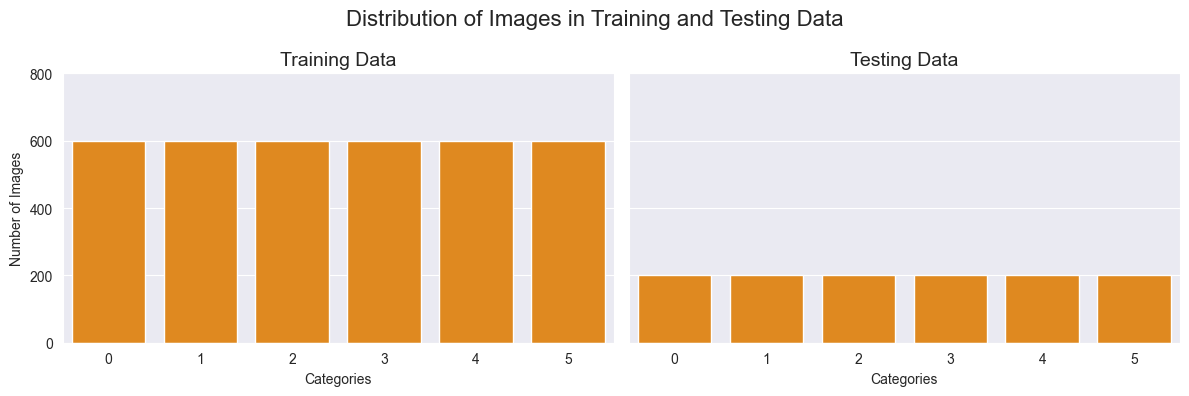

In [14]:
# Convert the training and testing data to Pandas DataFrames for easier plotting with Seaborn
train_df = pd.DataFrame(training_data, columns=['Image', 'Category'])
test_df = pd.DataFrame(testing_data, columns=['Image', 'Category'])

# Create subplots for displaying the distribution of images in training and testing data
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True, sharey=True)

# Plot the bar chart for the distribution of images in the training data using Seaborn
sns.countplot(x='Category', data=train_df, color='#FF8C00', ax=ax[0])  # Darker shade of orange
ax[0].set_title('Training Data', size=14)

# Plot the bar chart for the distribution of images in the testing data using Seaborn
sns.countplot(x='Category', data=test_df, color='#FF8C00', ax=ax[1])  # Darker shade of orange
ax[1].set_title('Testing Data', size=14)
ax[1].set_yticks(range(0, 801, 200))  # Set y-axis ticks for better visibility

# Set the overall title for the entire figure
fig.suptitle('Distribution of Images in Training and Testing Data', size=16)

# Set labels for the x-axis, y-axis, and overall figure
ax[0].set_xlabel('Categories')
ax[1].set_xlabel('Categories')
ax[0].set_ylabel('Number of Images')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


In [15]:
def print_dataset_summary(train_dataset, test_dataset):
    '''
    Print a summary of information about the training and testing datasets.

    Args:
    - train_dataset: Numpy array containing training dataset
    - test_dataset: Numpy array containing testing dataset
    '''
    # Print summary for the training dataset
    print(f'\nSummary for Training Dataset:\n')
    print(f'Shape: {train_dataset.shape}')
    print(f'Classes: {np.unique(train_dataset[:, 1])}')
    print(f'Number of Images in Each Class: {np.bincount(train_dataset[:, 1].astype(int))}')
    print(f'Maximum Pixel Value: {np.amax(train_dataset[0][0][:])}')  # Assuming the first image in the dataset

    # Print a separator line
    print('\n--------------------------------------\n')

    # Print summary for the testing dataset
    print(f'\nSummary for Testing Dataset:\n')
    print(f'Shape: {test_dataset.shape}')
    print(f'Classes: {np.unique(test_dataset[:, 1])}')
    print(f'Number of Images in Each Class: {np.bincount(test_dataset[:, 1].astype(int))}')
    print(f'Maximum Pixel Value: {np.amax(test_dataset[0][0][:])}')  # Assuming the first image in the dataset

    # Print a separator line
    print('\n--------------------------------------\n')



In [16]:
print_dataset_summary(training_data, testing_data)


Summary for Training Dataset:

Shape: (3600, 2)
Classes: [0 1 2 3 4 5]
Number of Images in Each Class: [600 600 600 600 600 600]
Maximum Pixel Value: 255

--------------------------------------


Summary for Testing Dataset:

Shape: (1200, 2)
Classes: [0 1 2 3 4 5]
Number of Images in Each Class: [200 200 200 200 200 200]
Maximum Pixel Value: 255

--------------------------------------


In [17]:
def display_images(num, image_array, title, columns=1):
    '''
    Display images in their original state before any pre-processing.

    Args:
    - num: Total number of images to display
    - image_array: Array containing image data and associated labels
    - title: Title for the entire display
    - columns: Number of columns for the image grid (default is 1)
    '''
    columns = columns
    rows = int(num / columns)

    # Create a subplot for displaying images
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 4, rows * 4))
    fig.suptitle(title, size=20)
    axes = axes.ravel()

    # Loop through the specified number of images
    for i in range(num):
        # Display the original image along with its associated label
        axes[i].imshow(image_array[i][0])
        axes[i].set_title(label_shape.get(image_array[i][1]), size=16)



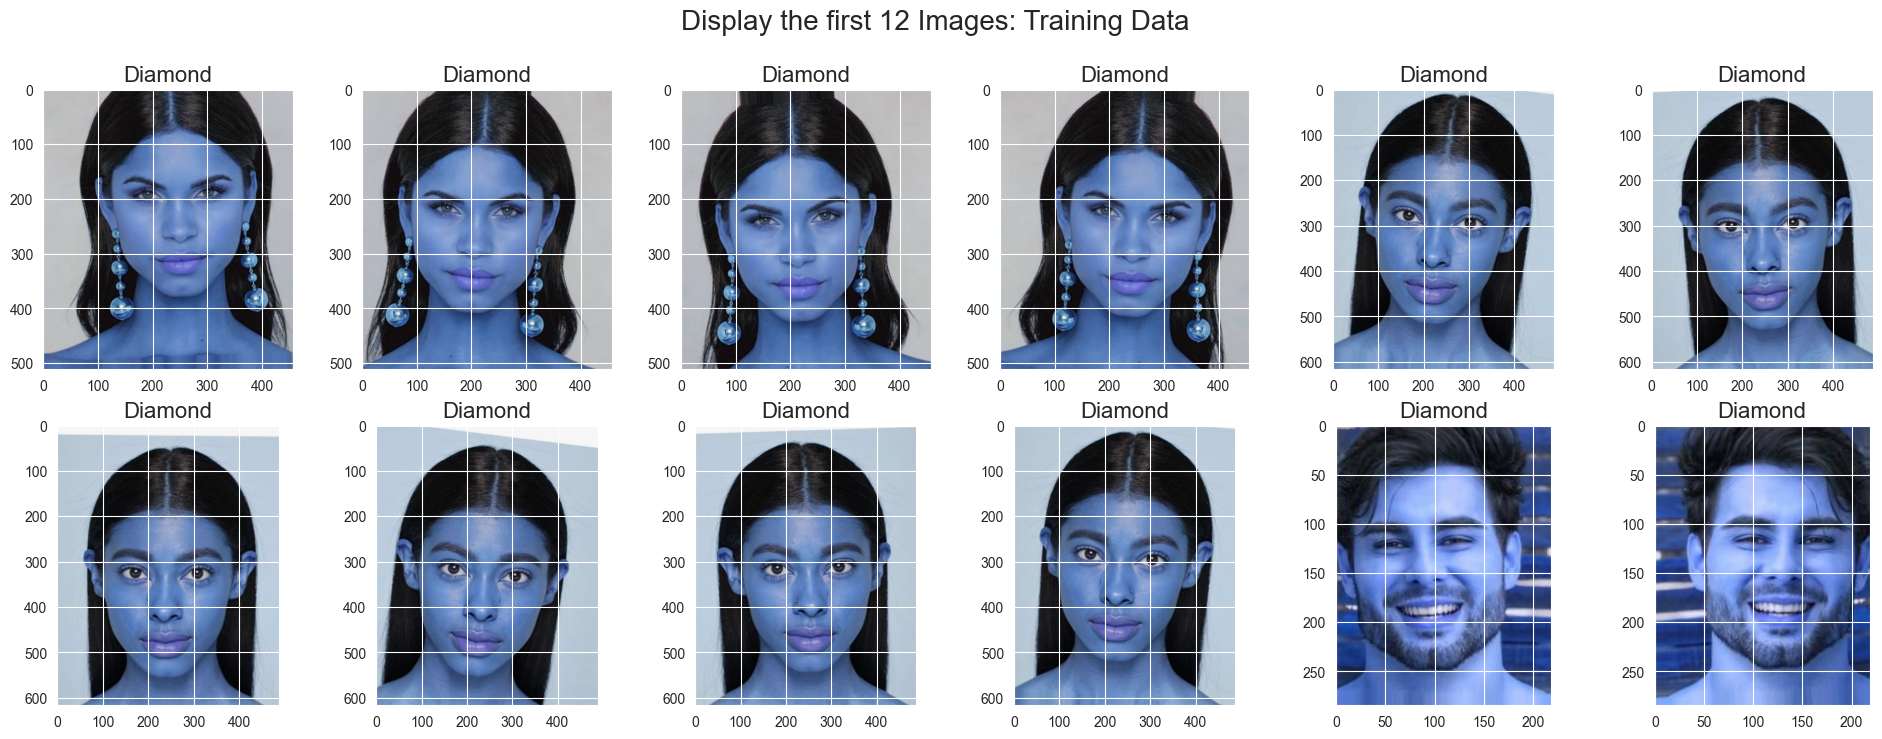

In [18]:
display_images(12, training_data[:12], 'Display the first 12 Images: Training Data', columns=6)

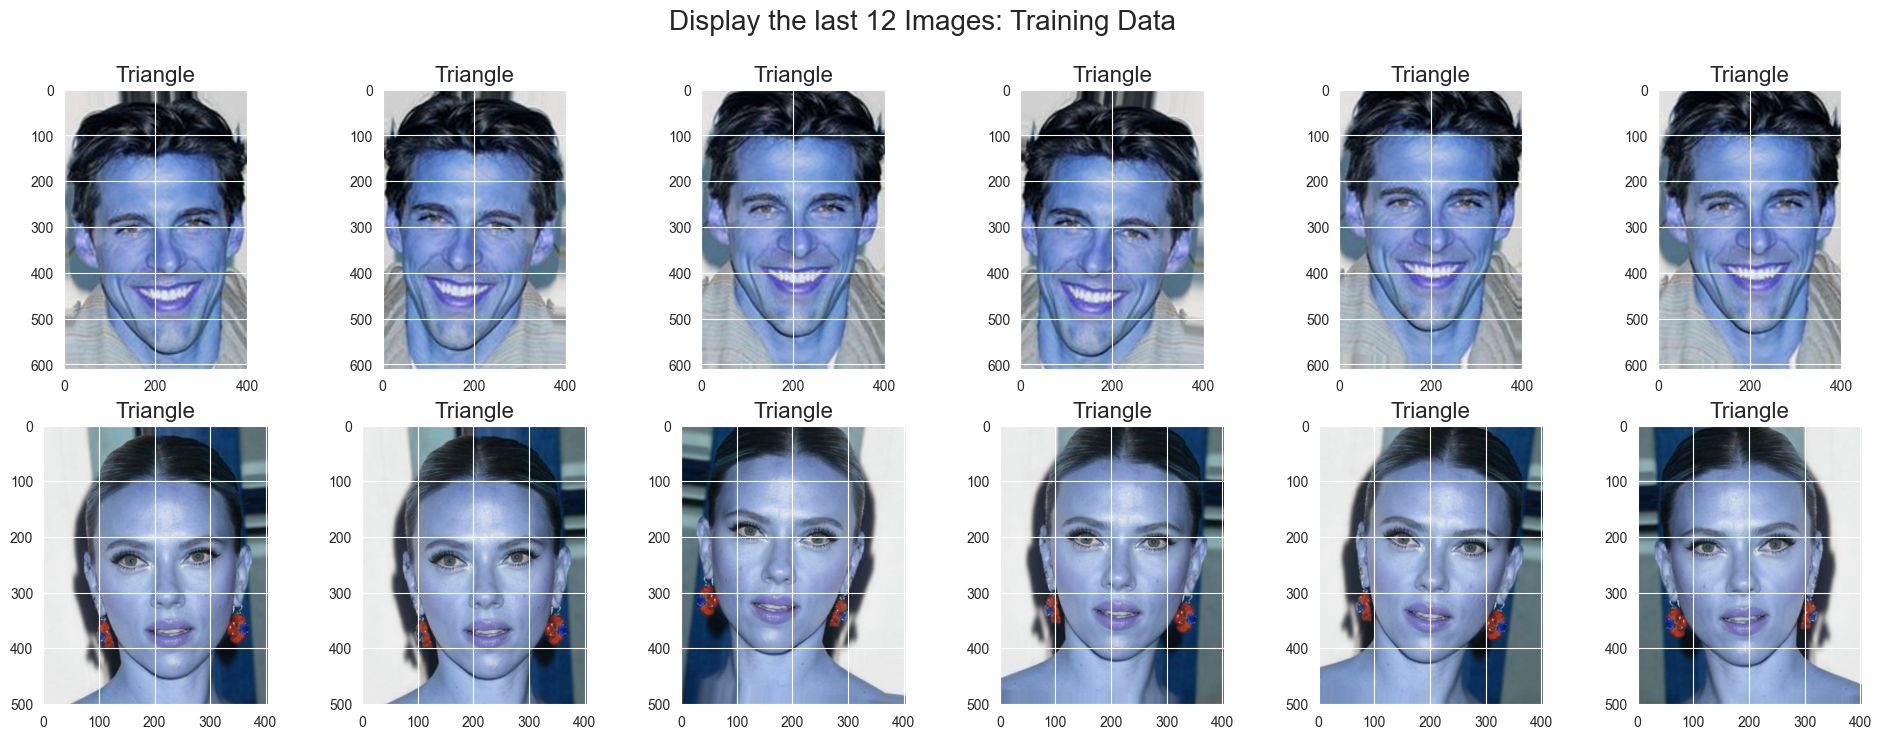

In [19]:
display_images(12, training_data[len(training_data)-12:], 'Display the last 12 Images: Training Data', columns=6)

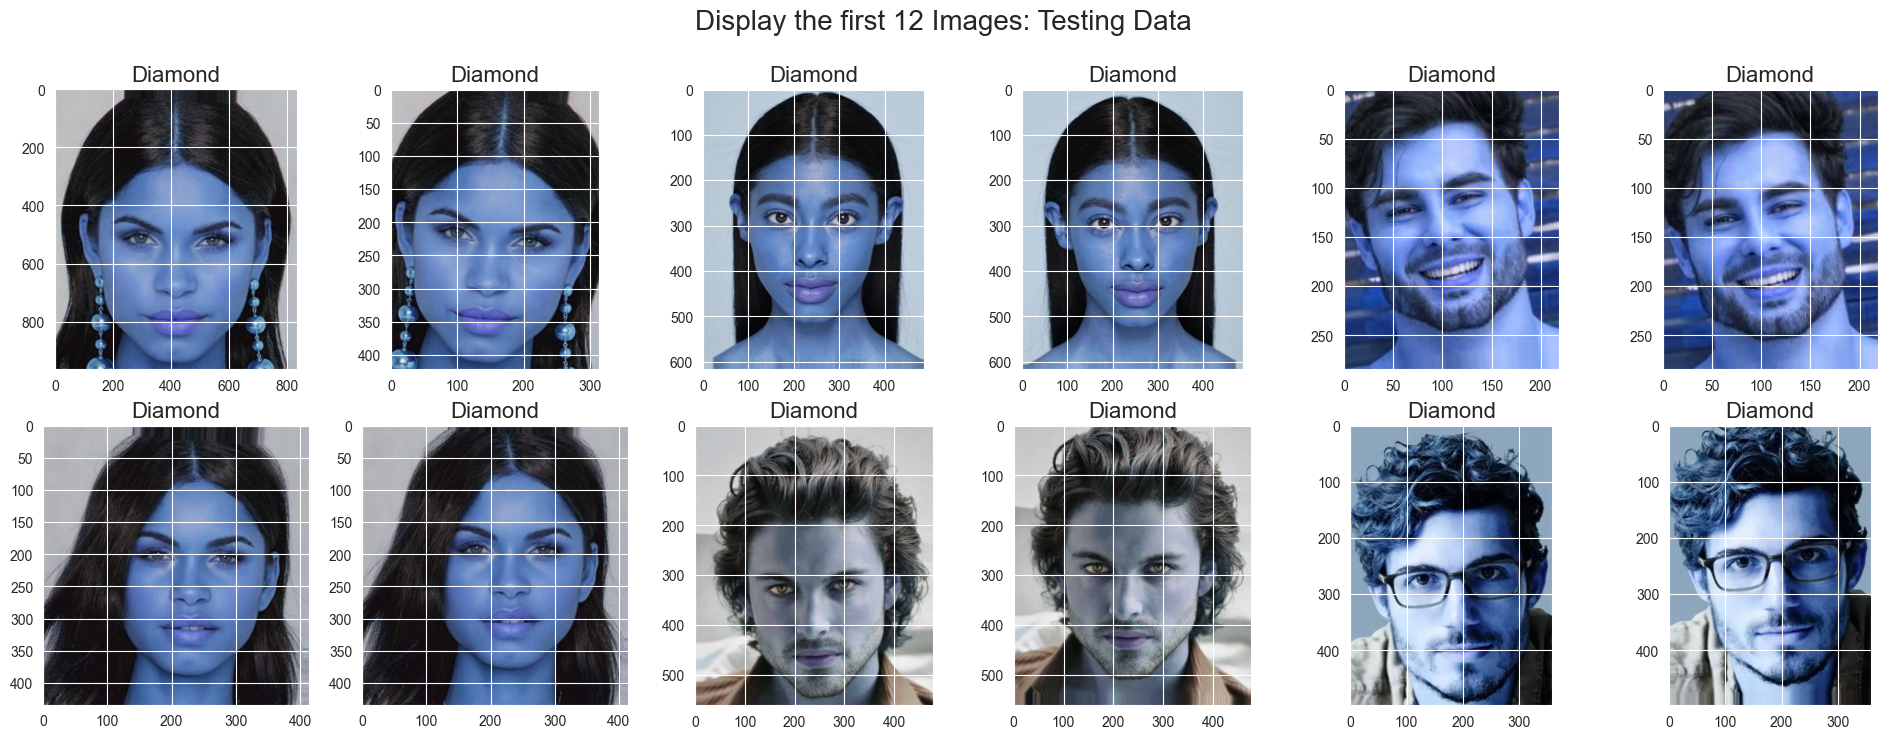

In [20]:
display_images(12, testing_data[:12], 'Display the first 12 Images: Testing Data', columns=6)

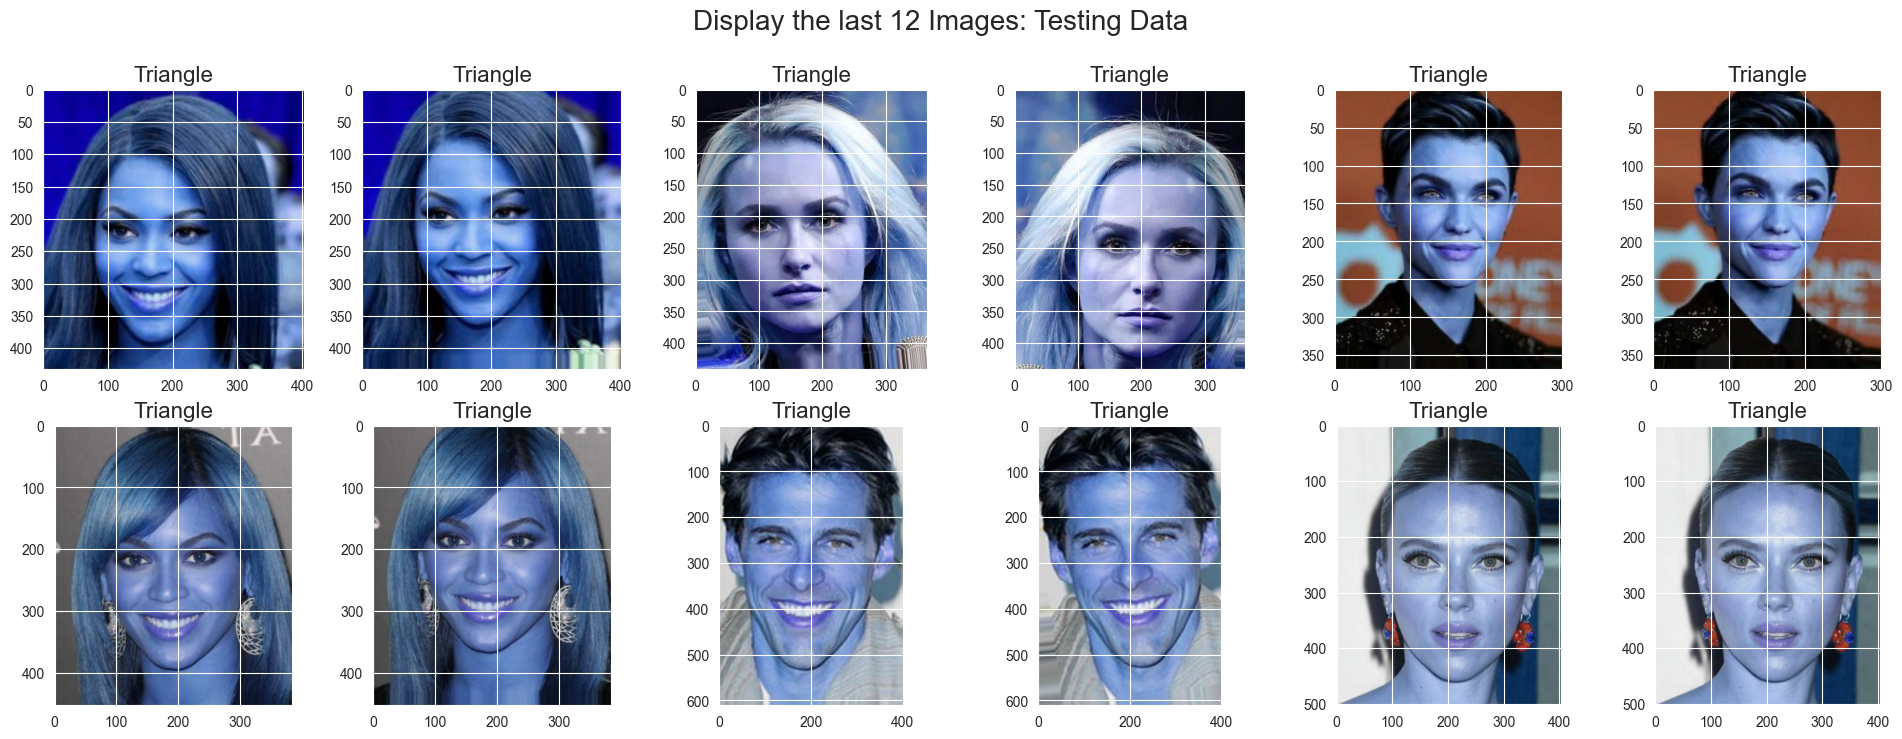

In [21]:
display_images(12, testing_data[len(testing_data)-12:], 'Display the last 12 Images: Testing Data', columns=6)

# Explanatory Data Analysis

The pictures come in various dimensions, thus it is necessary to standardize the sizes of all the images prior to executing a model. Common input dimensions for CNN include:  
   - VGG16 and Resnet50: 224 x 224 x 3
   - Inception V3: 299 x 299 x 3

In [23]:
# Initialize an empty list to store image shapes
shape = []

# Loop through each image and label in the training_data
for image, label in training_data:
    try:
        # Get the shape of the image and append it to the 'shape' list
        img_shape = image.shape
        shape.append(img_shape)
    except AttributeError:
        # Handle the case where the shape is not found (e.g., for non-image data)
        print("Shape not found")

# Display the first six elements of the 'shape' list
shape[:6]


[(512, 457, 3),
 (512, 457, 3),
 (512, 457, 3),
 (512, 457, 3),
 (617, 488, 3),
 (617, 488, 3)]

In [24]:
# Create a DataFrame with the images, their shapes, and additional information
train = pd.DataFrame(training_data, columns=['image_array', 'class'])

# Add a new column 'image_shape' to the DataFrame using the 'shape' list
train['image_shape'] = pd.Series(shape)

# Map the 'class' column to 'face_shape' using the 'label_shape' dictionary
train['face_shape'] = train['class'].map(label_shape)

# Display the first two rows of the DataFrame
train.head(2)


image_array class    image_shape  \
0  [[[190, 188, 188], [190, 188, 188], [190, 188,...     0  (512, 457, 3)   
1  [[[189, 190, 194], [189, 190, 194], [189, 190,...     0  (512, 457, 3)   

  face_shape  
0    Diamond  
1    Diamond

In [25]:
train.sort_values(by='image_shape', ascending=False)

image_array class  \
1645  [[[223, 216, 207], [224, 217, 208], [224, 217,...     2   
1650  [[[209, 203, 196], [209, 203, 196], [209, 203,...     2   
1649  [[[221, 216, 215], [221, 216, 215], [221, 216,...     2   
1648  [[[209, 203, 198], [209, 203, 198], [209, 203,...     2   
1647  [[[217, 214, 206], [217, 214, 206], [217, 214,...     2   
...                                                 ...   ...   
3254  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...     5   
3255  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...     5   
3253  [[[223, 218, 219], [223, 218, 219], [223, 218,...     5   
3252  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...     5   
3251  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...     5   

          image_shape face_shape  
1645  (3504, 2336, 3)       Oval  
1650  (3504, 2336, 3)       Oval  
1649  (3504, 2336, 3)       Oval  
1648  (3504, 2336, 3)       Oval  
1647  (3504, 2336, 3)       Oval  
...               ...        ...  
3254    (192, 152, 3)   Triangle  
3255    (192, 152, 3)   Triangle  
3253    (192, 152, 3)   Triangle  
3252    (192, 152, 3)   Triangle  
3251    (192, 152, 3)   Triangle  

[3600 rows x 4 columns]

In [26]:
# Check the info, make sure there are no null values

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_array  3600 non-null   object
 1   class        3600 non-null   object
 2   image_shape  3600 non-null   object
 3   face_shape   3600 non-null   object
dtypes: object(4)
memory usage: 112.6+ KB


In [27]:
# Add columns for Height, Width, and Aspect Ratio to the 'train' DataFrame for further analysis
train['height'] = train['image_shape'].map(lambda x: x[0])
train['width'] = train['image_shape'].map(lambda x: x[1])
train['aspect_ratio'] = train['width'] / train['height']

# Display the updated 'train' DataFrame
train

image_array class    image_shape  \
0     [[[190, 188, 188], [190, 188, 188], [190, 188,...     0  (512, 457, 3)   
1     [[[189, 190, 194], [189, 190, 194], [189, 190,...     0  (512, 457, 3)   
2     [[[189, 190, 194], [189, 190, 194], [189, 190,...     0  (512, 457, 3)   
3     [[[189, 184, 185], [189, 184, 185], [189, 184,...     0  (512, 457, 3)   
4     [[[180, 196, 208], [180, 196, 208], [180, 196,...     0  (617, 488, 3)   
...                                                 ...   ...            ...   
3595  [[[236, 236, 236], [236, 236, 236], [236, 236,...     5  (503, 404, 3)   
3596  [[[93, 114, 116], [93, 114, 116], [92, 113, 11...     5  (503, 404, 3)   
3597  [[[234, 236, 236], [234, 236, 236], [234, 236,...     5  (503, 404, 3)   
3598  [[[233, 238, 237], [233, 238, 237], [233, 238,...     5  (503, 404, 3)   
3599  [[[94, 113, 116], [94, 113, 116], [94, 113, 11...     5  (503, 404, 3)   

     face_shape  height  width  aspect_ratio  
0       Diamond     512    457      0.892578  
1       Diamond     512    457      0.892578  
2       Diamond     512    457      0.892578  
3       Diamond     512    457      0.892578  
4       Diamond     617    488      0.790924  
...         ...     ...    ...           ...  
3595   Triangle     503    404      0.803181  
3596   Triangle     503    404      0.803181  
3597   Triangle     503    404      0.803181  
3598   Triangle     503    404      0.803181  
3599   Triangle     503    404      0.803181  

[3600 rows x 7 columns]

In [28]:
train.describe()

height        width  aspect_ratio
count  3600.000000  3600.000000   3600.000000
mean    516.063333   424.691667      0.833375
std     272.504944   213.645966      0.113126
min     192.000000   152.000000      0.577500
25%     383.000000   314.000000      0.751295
50%     479.000000   400.000000      0.816038
75%     574.000000   466.000000      0.904762
max    3504.000000  2510.000000      1.333333

In [38]:
def subplot_histograms(dataframe, list_of_columns, list_of_titles, list_of_xlabels, list_of_ylabels,
                       figsize=(10,8), bins=15, ncols=2, nrows=0, sharex=True, sharey=True, figtitle=None,
                       palette=None):
    """
    Plot histograms with subplots in matplotlib.

    Args:
    - dataframe: Pandas DataFrame containing the data
    - list_of_columns: List of column names to plot histograms for
    - list_of_titles: List of titles for each subplot
    - list_of_xlabels: List of x-axis labels for each subplot
    - list_of_ylabels: List of y-axis labels for each subplot
    - figsize: Tuple specifying the figure size (default is (10, 8))
    - bins: Number of bins for the histograms (default is 15)
    - ncols: Number of columns for subplots (default is 2)
    - nrows: Number of rows for subplots (default is 0, calculated based on len(list_of_columns))
    - sharex: Whether to share the x-axis among subplots (default is True)
    - sharey: Whether to share the y-axis among subplots (default is True)
    - figtitle: Title for the entire figure (default is None)
    - palette: Palette of colors to use for each subplot

    Note: Uncomment the last line if you want to save the plot as a PNG file.
    """
    if nrows == 0:
        nrows = int(np.ceil(len(list_of_columns) / 2))  # Makes sure you have enough rows

    # Create subplots based on specified parameters
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, sharex=sharex, sharey=sharey)
    fig.suptitle(figtitle, fontsize=16)
    ax = ax.ravel()  # Ravel turns a matrix into a vector, which is easier to iterate

    # Iterate over each column to create histograms in subplots
    for i, column in enumerate(list_of_columns):
        # Set the palette color for the current subplot
        current_palette = None if palette is None else palette[i]

        # Create the histogram for the current column
        ax[i].hist(dataframe[column], bins=bins, color=current_palette)
        ax[i].set_title(list_of_titles[i])  # Set titles for each subplot
        if (i >= (ncols * nrows) / 2):
            ax[i].set_xlabel(list_of_xlabels[i])  # Only show x labels on bottom ax plots
        if (sharey == True) and (i % ncols == 0):
            ax[i].set_ylabel(list_of_ylabels[i])  # Only show y labels on left ax plots

    # Adjust layout for better spacing
    plt.tight_layout()

    # Uncomment the next line if you want to save the plot as a PNG file
    # plt.savefig(f'../plots/{figtitle}.png');


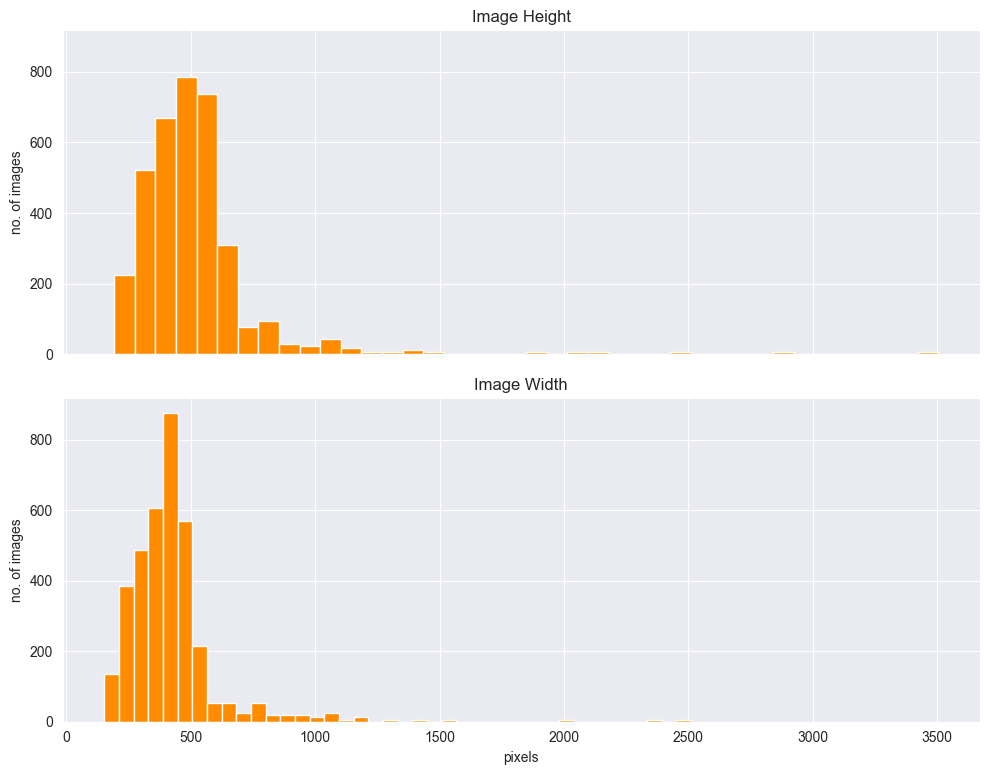

In [39]:
# Set the Seaborn style to 'darkgrid'
sns.set_style('darkgrid')

# Call the subplot_histograms function to plot histograms for 'height' and 'width' columns in the 'train' DataFrame
# Set the palette to a darker shade of orange using the 'darkorange' color code
subplot_histograms(train, ['height', 'width'],
                   ['Image Height', 'Image Width'],
                   ['pixels', 'pixels'],
                   ['no. of images', 'no. of images'],
                   figsize=(10, 8), bins=40, ncols=1, nrows=2,
                   sharex=True, sharey=True, figtitle=None,
                   palette=['darkorange', 'darkorange'])



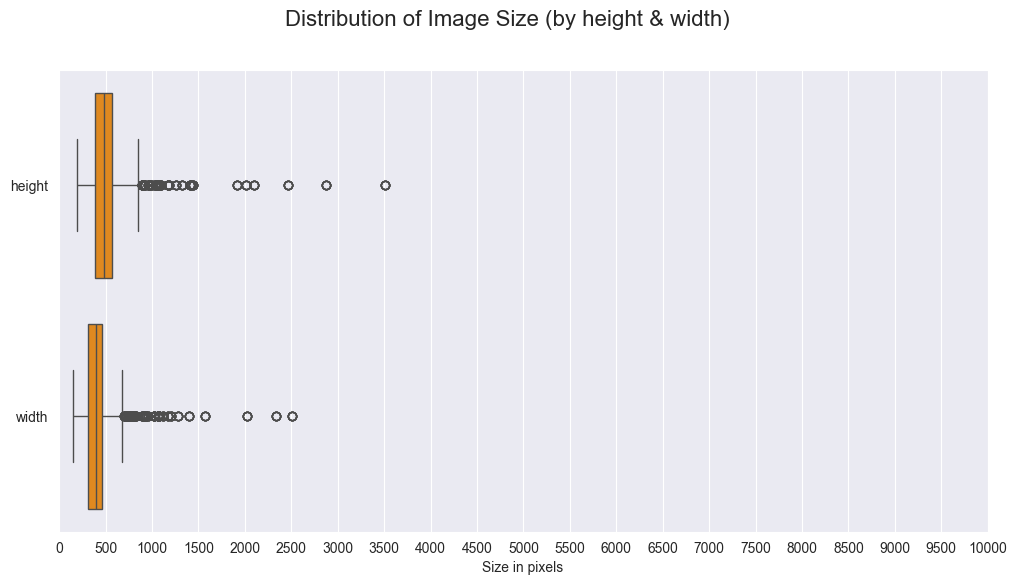

In [36]:
# Create a subplot with a specified size
fig, ax = plt.subplots(figsize=(12, 6))

# Set the main title for the figure
fig.suptitle('Distribution of Image Size (by height & width)', fontsize=16)

# Create a horizontal boxplot for the 'height' and 'width' columns in the 'train' DataFrame
# Set the boxplot color to a darker shade of orange using the 'darkorange' color code
sns.boxplot(data=train[['height', 'width']], orient='h', palette=['darkorange', 'darkorange'])

# Set the x-axis label
ax.set_xlabel('Size in pixels')

# Set custom x-axis ticks at intervals of 500 pixels from 0 to 10000
ax.set_xticks(range(0, 10001, 500))

# Uncomment the next line if you want to add a stripplot on top of the boxplot
# This stripplot may provide additional insights into the distribution of data points
# sns.stripplot(data=train[['height', 'width']], orient='h', alpha=0.05)

# Display the plot
plt.show()



Most of the images are small sizes (less than 1000 pixels) with a number of outliers

Most of the images are portrait mode with few squares and landscape.  We need to resize them into squares for modelling


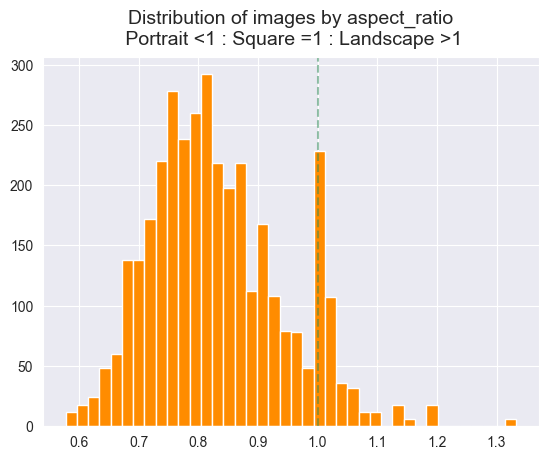

In [40]:
# Create a histogram for the 'aspect_ratio' column in the 'train' DataFrame
plt.hist(train['aspect_ratio'], bins=40, color='darkorange')

# Set the title for the histogram
plt.title('Distribution of images by aspect_ratio\n Portrait <1 : Square =1 : Landscape >1', fontsize=14, y=1.01)

# Add a vertical line at x=1 with a dashed linestyle and seagreen color
plt.axvline(x=1, alpha=0.5, linestyle='--', color='seagreen')

# Display the plot
plt.show()


C:\Users\iamso\AppData\Local\Temp\ipykernel_2404\2286970098.py:7: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.catplot(data=train, x='aspect_ratio', y='face_shape', palette=['darkorange'], hue='face_shape', legend=False)


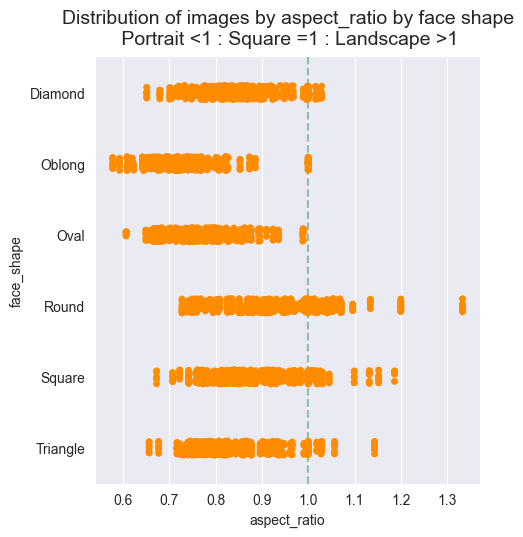

In [44]:
# Set the super title for the entire figure
fig.suptitle('Image by Aspect Ratio (square=1)')

# Create a categorical plot (catplot) using Seaborn to display the distribution of 'aspect_ratio' by 'face_shape'
# Set the color palette to a custom color ('darkorange') for the plot
# Assign 'face_shape' to the 'hue' parameter and set 'legend' to False
sns.catplot(data=train, x='aspect_ratio', y='face_shape', palette=['darkorange'], hue='face_shape', legend=False)

# Set the title for the catplot
plt.title('Distribution of images by aspect_ratio by face shape\n Portrait <1 : Square =1 : Landscape >1', fontsize=14, y=1.01)

# Add a vertical line at x=1 with a dashed linestyle and seagreen color
plt.axvline(x=1, alpha=0.5, linestyle='--', color='seagreen')

# Display the plot
plt.show()


